## 1. **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split

## 2. **Get Data**

### 2.1 **Load datasets**

In [2]:
# Load application record and credit record data into DataFrames
cc_application_df = pd.read_csv('data/application_record.csv')
cc_status_df = pd.read_csv('data/credit_record.csv')

### 2.2. **Create target variable**

In [3]:
# Determine how long each person has held their credit card
cc_duration = cc_status_df.groupby("ID")["MONTHS_BALANCE"].min().reset_index().rename(columns={"MONTHS_BALANCE": "months_hold_cc"})
cc_application_df = pd.merge(cc_application_df, cc_duration, how="left", on="ID")

# Create a new column 'is_risky' that identifies if the STATUS is considered risky (values 2, 3, 4, or 5)
cc_status_df['is_risky'] = np.where(cc_status_df['STATUS'].isin(['2', '3', '4', '5']), 'Yes', 'No')

# Determine if a person has ever defaulted, with Yes mapped to 1 and No mapped to 0
cc_defaulter = cc_status_df.groupby('ID')['is_risky'].max().reset_index()
cc_defaulter['is_risky'] = cc_defaulter['is_risky'].map({'Yes': 1, 'No': 0})
cc_application_df = pd.merge(cc_application_df, cc_defaulter, how='inner', on='ID')

# Ensure duration is positive and convert it to integer type for consistent data handling
cc_application_df['months_hold_cc'] = np.abs(cc_application_df['months_hold_cc']).astype('int64')

### 2.3 **Rename features**

In [4]:
# Define a mapping to rename DataFrame columns for clarity and consistency
column_rename_map = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_property',
    'CNT_CHILDREN': 'child_count',
    'AMT_INCOME_TOTAL': 'annual_income',
    'NAME_INCOME_TYPE': 'work_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'marital_status',
    'NAME_HOUSING_TYPE': 'accommodation',
    'DAYS_BIRTH': 'days_lived',
    'DAYS_EMPLOYED': 'days_employed',
    'FLAG_MOBIL': 'has_mobile',
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'profession',
    'CNT_FAM_MEMBERS': 'family_size'
}
cc_application_df.rename(columns=column_rename_map, inplace=True)

### 2.4. **Split data**

In [5]:
# DataFrame before splitting data
final_df = cc_application_df.drop(columns=['ID'])

# Split the data into train and test sets
def data_split(df, size):
    train_df, test_df = train_test_split(df, test_size=size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

cc_train_original, cc_test_original = data_split(final_df, 0.2)

## 3. **Exploratory Data Analysis (EDA)**

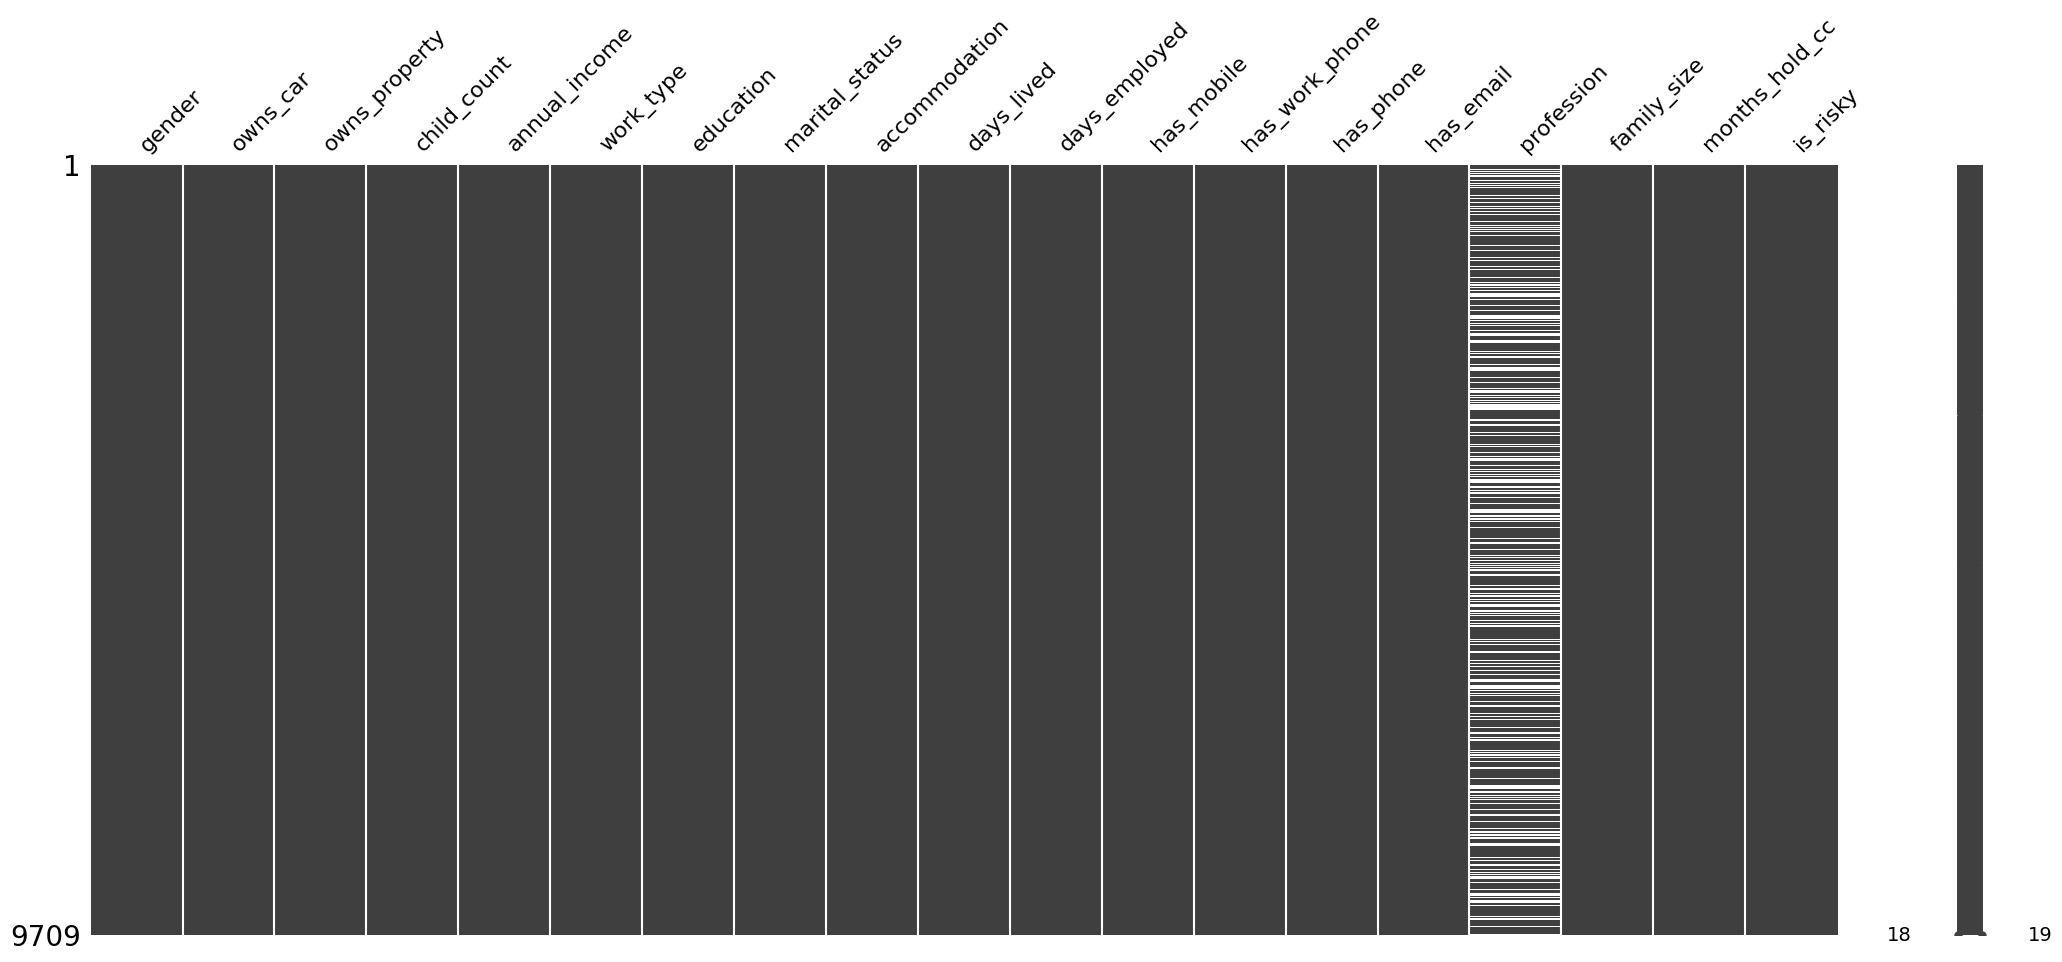

In [6]:
msno.matrix(final_df)
plt.show()

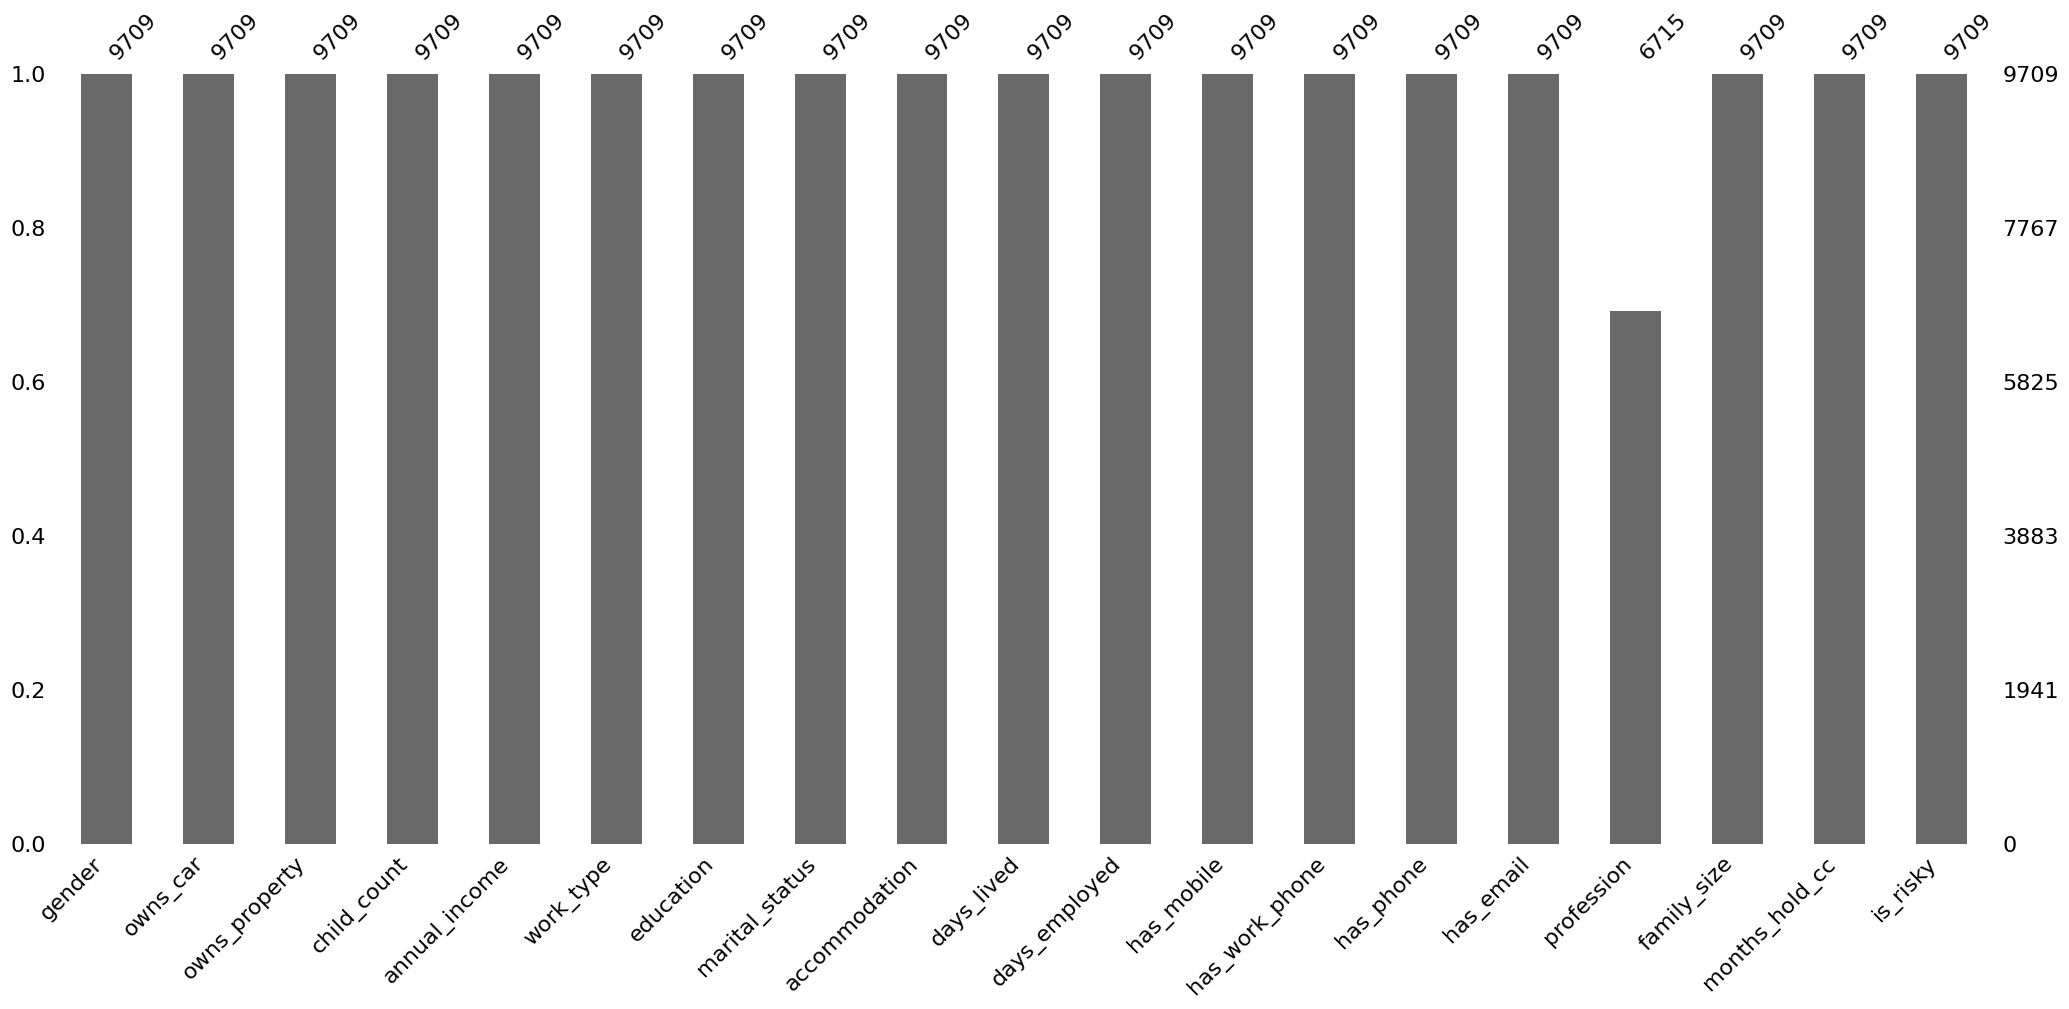

In [7]:
msno.bar(final_df)
plt.show()

In [8]:
# Create a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [9]:
#Function that will return the count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [10]:
# Function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'days_lived':
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case 'annual_income':
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))

        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Data type: {}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('{}'.format(value_cnt))

In [11]:
# Function to create a bar chart plot
def create_bar_plot(df, feature):
    value_counts = df[feature].value_counts()
    
    match feature:
        case 'marital_status':
            custom_labels = ['Married', 'Single', 'Civil Marriage', 'Divorced', 'Widow']
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
            plt.xlabel("Marital Status")
            plt.ylabel("Count")
            plt.title("Distribution of Marital Status")
        
        case 'accommodation':
            custom_labels = [
                'Private\nResidence', 'Public\nHousing', 'With\nParents', 
                'Rented', 'Corporate\nHousing', 'Cooperative\nHousing'
            ]
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
            plt.xlabel("Accommodation Type")
            plt.ylabel("Count")
            plt.title("Distribution of Accommodation Type")
        
        case _:
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.xlabel(f"{feature.replace('_', ' ').title()}")
            plt.ylabel("Count")
            plt.title(f"Distribution of {feature.replace('_', ' ').title()}")
    
    plt.show()

In [12]:
# Function to create a pie chart plot
def create_pie_plot(df, feature):
    value_counts = df[feature].value_counts(normalize=True) * 100
    
    match feature:
        case 'gender':
            labels = ['Female', 'Male']
            plt.pie(value_counts, labels=labels, autopct='%1.0f%%')
            plt.title('Proportion of Gender')
        
        case 'marital_status':
            labels = ['Married', 'Single', 'Civil Marriage', 'Divorced', 'Widow']
            plt.pie(value_counts, labels=labels, autopct='%1.0f%%')
            plt.title('Proportion of Marital Status')
        
        case 'accommodation':
            labels = [
                'Private\nResidence', 'With\nParents', 'Public\nHousing', 
                'Rented', 'Corporate Housing', 'Cooperative Housing'
            ]
            explode = [0, 0.05, 0.15, 0.3, 0.5, 0.7]
            colors = sns.color_palette('Set3')
            plt.pie(value_counts, labels=labels, autopct='%1.0f%%', startangle=270, explode=explode, colors=colors)
            plt.title('Proportion of Accommodation Type')
        
        case _:
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.0f%%')
            plt.title(f'{feature.replace("_", " ").title()} Distribution')
    
    plt.show()

In [13]:
# Function to create a histogram plot
def create_hist_plot(df, feature):
    match feature:
        case 'days_lived':
            sns.histplot(np.abs(df[feature]) / 365.25, bins=50, kde=True)
            plt.xlabel('Age (Years)')
            plt.ylabel('Count')
            plt.title('Age Distribution (Histogram)')
        
        case 'annual_income':
            income_formatter = lambda x, _: f'{int(x / 100000)}'
            sns.histplot(df[feature], bins=50, kde=True)
            plt.gca().get_xaxis().set_major_formatter(mtick.FuncFormatter(income_formatter))
            plt.xlabel('Annual Income (Lakh)')
            plt.ylabel('Count')
            plt.title('Annual Income Distribution (Histogram)')
        
        case _:
            sns.histplot(df[feature], bins=50, kde=True)
            plt.xlabel(feature.replace('_', ' ').title())
            plt.ylabel('Count')
            plt.title(f'{feature.replace("_", " ").title()} Distribution (Histogram)')
    
    plt.show()

In [14]:
# Function to create a Boxplot
def create_boxplot(df, feature):
    match feature:
        case 'days_lived':
            sns.boxplot(y=np.abs(df[feature]) / 365.25)
            plt.title('Age Distribution (Boxplot)')
            plt.ylabel('Age (Years)')

        case 'annual_income':
            sns.boxplot(y=df[feature])
            plt.title('Annual Income Distribution (Boxplot)')
            plt.ylabel('Annual Income (Lakh)')
        
        case _:
            sns.boxplot(y=df[feature])
            plt.title(f'{feature.replace("_", " ").title()} Distribution (Boxplot)')
            plt.ylabel(feature.replace("_", " ").title())
    
    plt.show()

In [15]:
# Function to create a Low/High Risk Boxplot
def low_high_risk_boxplot(df, feature):
    match feature:
        case 'days_lived':
            df['Age (Years)'] = np.abs(df[feature]) / 365.25
            sns.boxplot(x=df['is_risky'], y=df['Age (Years)'])
            plt.xticks(ticks=[0, 1], labels=["Low", "High"])
            plt.title('Low & High Risk Individuals: By Age (Boxplot)')
            plt.xlabel('Risk')
            plt.ylabel('Age (Years)')
        
        case 'annual_income':
            ax = sns.boxplot(x=df['is_risky'], y=df[feature])
            ax.get_yaxis().set_major_formatter(
                mtick.FuncFormatter(lambda x, _: f'{int(x / 100000)}')
            )
            plt.xticks(ticks=[0, 1], labels=["Low", "High"])
            plt.title('Low & High Risk Individuals: By Income (Boxplot)')
            plt.xlabel('Risk')
            plt.ylabel('Annual Income (Lakh)')
            
        case _:
            if df[feature].dtype in [np.int64, np.float64]:
                sns.boxplot(x=df['is_risky'], y=df[feature])
                plt.xticks(ticks=[0, 1], labels=["Low", "High"])
                plt.title(f'Low & High Risk Individuals: By {feature.replace("_", " ").title()} (Boxplot)')
                plt.xlabel('Risk')
                plt.ylabel(feature.replace("_", " ").title())
            else:
                print(f"Feature '{feature}' is not suitable for a numerical boxplot. Consider using categorical analysis.")

    plt.show()

In [16]:
# Function to create a Low/High Risk Barplot
def low_high_risk_barplot(df, feature):
    aggregated_data = df.groupby(feature)['is_risky'].sum().sort_values(ascending=False)

    sns.barplot(x=aggregated_data.index, y=aggregated_data.values)
    
    if feature == 'marital_status':
        custom_labels = ['Married', 'Single', 'Civil Marriage', 'Widow', 'Divorced']
        plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Count')
    plt.title(f'High Risk Individuals: By {feature.replace("_", " ").title()} (Barplot)')
    plt.show()

### 3.1 **Gender**

In [17]:
gen_info_feat(cc_train_copy, 'gender')

Description:
count     7767
unique       2
top          F
freq      5029
Name: gender, dtype: object
**************************************************
Data type: object
**************************************************
        Count  Frequency (%)
gender                      
F        5029      64.748294
M        2738      35.251706


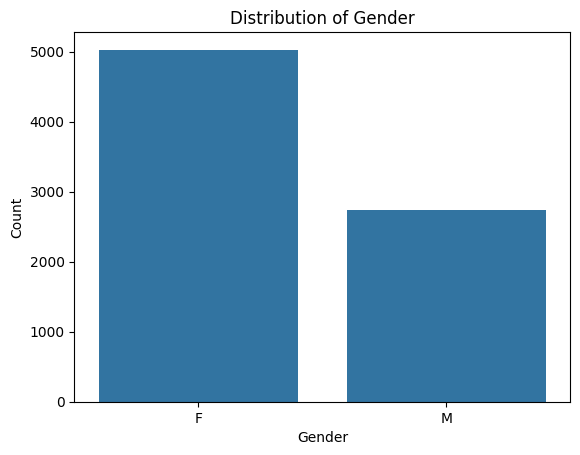

In [18]:
create_bar_plot(cc_train_copy, 'gender')

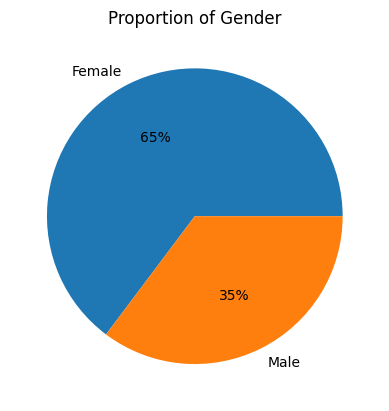

In [19]:
create_pie_plot(cc_train_copy, 'gender')

### 3.2 **Age**

In [20]:
gen_info_feat(cc_train_copy, 'days_lived')

Description:
count    7767.000000
mean       43.822532
std        11.593486
min        21.095140
25%        34.083504
50%        42.787132
75%        53.564682
max        68.862423
Name: days_lived, dtype: float64
**************************************************
Data type: int64


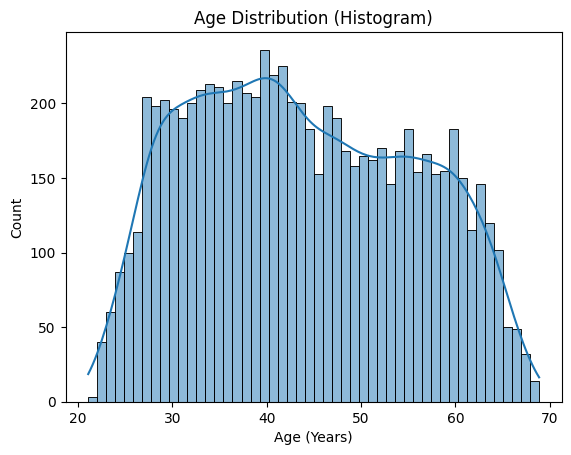

In [21]:
create_hist_plot(cc_train_copy, 'days_lived')

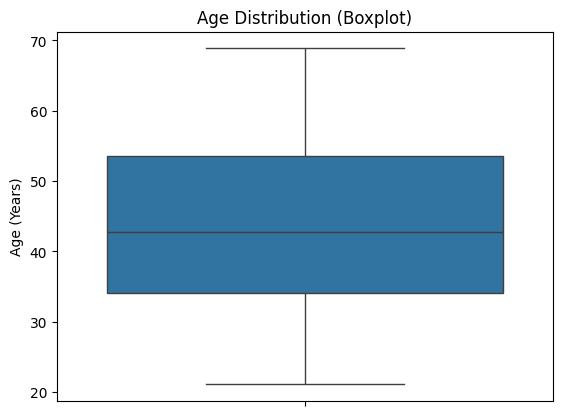

In [22]:
create_boxplot(cc_train_copy, 'days_lived')

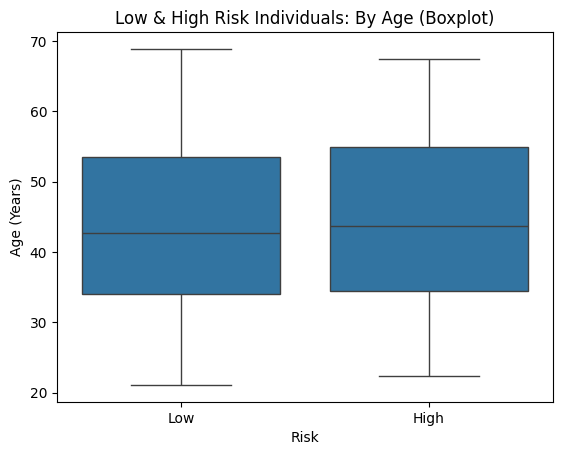

In [23]:
low_high_risk_boxplot(cc_train_copy, 'days_lived')

### 3.3 **Marital Status**

In [24]:
gen_info_feat(cc_train_copy, 'marital_status')

Description:
count        7767
unique          5
top       Married
freq         5227
Name: marital_status, dtype: object
**************************************************
Data type: object
**************************************************
                      Count  Frequency (%)
marital_status                            
Married                5227      67.297541
Single / not married   1088      14.007982
Civil marriage          666       8.574739
Separated               457       5.883868
Widow                   329       4.235870


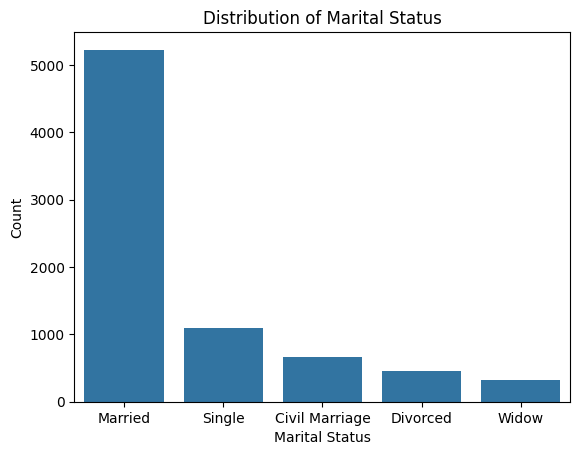

In [25]:
create_bar_plot(cc_train_copy, 'marital_status')

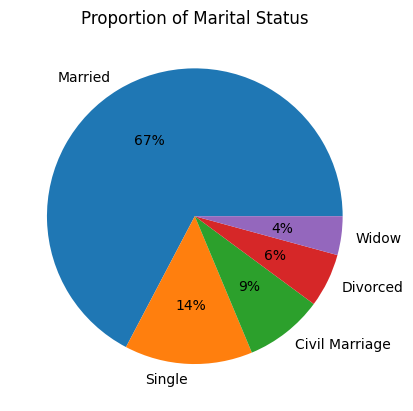

In [26]:
create_pie_plot(cc_train_copy, 'marital_status')

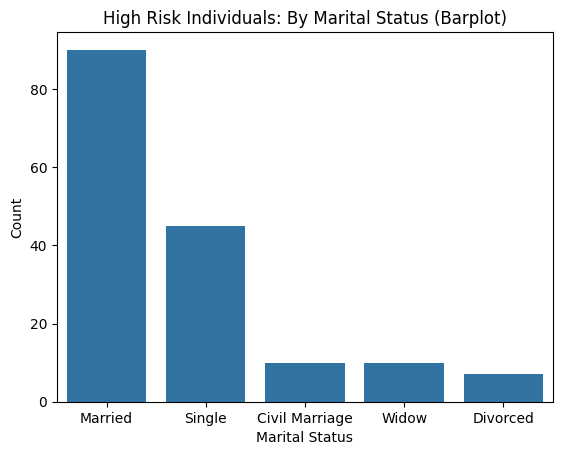

In [27]:
low_high_risk_barplot(cc_train_copy, 'marital_status')

### 5.4 **Family Size**

In [28]:
gen_info_feat(cc_train_copy, 'family_size')

Description:
count    7767.000000
mean        2.184241
std         0.942279
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: family_size, dtype: float64
**************************************************
Data type: float64
**************************************************
             Count  Frequency (%)
family_size                      
2.0           4147      53.392558
1.0           1559      20.072100
3.0           1297      16.698854
4.0            650       8.368740
5.0             93       1.197374
6.0             14       0.180250
7.0              4       0.051500
15.0             1       0.012875
9.0              1       0.012875
20.0             1       0.012875


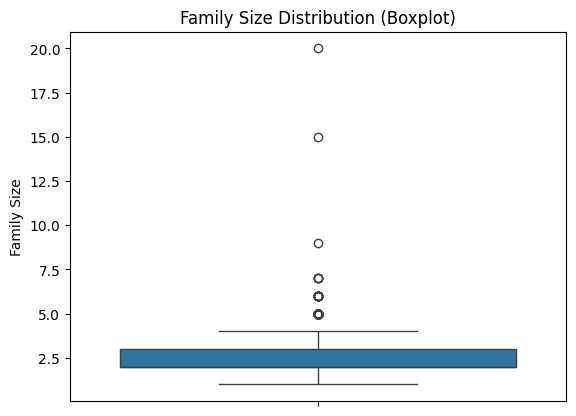

In [29]:
create_boxplot(cc_train_copy, 'family_size')

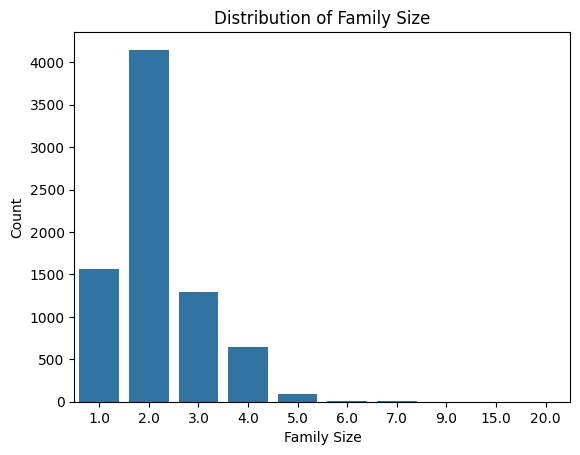

In [30]:
create_bar_plot(cc_train_copy, 'family_size')

### 3.5 **Children Count**

In [31]:
gen_info_feat(cc_train_copy, 'child_count')

Description:
count    7767.000000
mean        0.423716
std         0.778985
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        19.000000
Name: child_count, dtype: float64
**************************************************
Data type: int64
**************************************************
             Count  Frequency (%)
child_count                      
0             5466      70.374662
1             1488      19.157976
2              691       8.896614
3              100       1.287498
4               14       0.180250
5                5       0.064375
14               1       0.012875
7                1       0.012875
19               1       0.012875


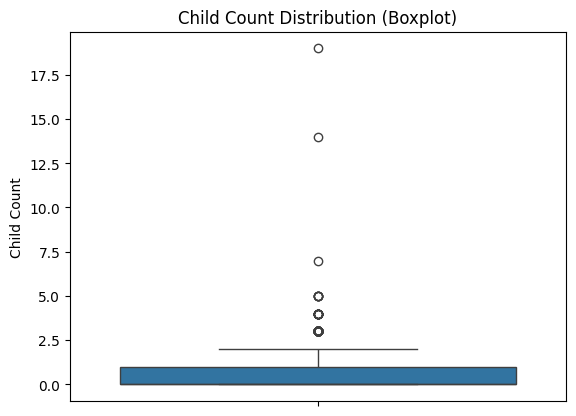

In [32]:
create_boxplot(cc_train_copy, 'child_count')

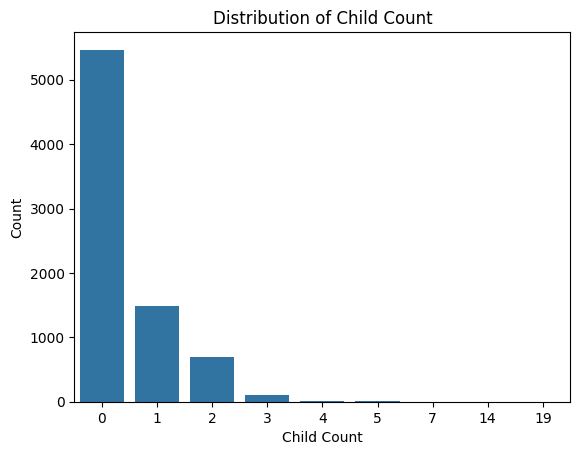

In [33]:
create_bar_plot(cc_train_copy, 'child_count')

### 3.6 **Accommodation**

In [34]:
gen_info_feat(cc_train_copy, 'accommodation')

Description:
count                  7767
unique                    6
top       House / apartment
freq                   6939
Name: accommodation, dtype: object
**************************************************
Data type: object
**************************************************
                     Count  Frequency (%)
accommodation                            
House / apartment     6939      89.339513
With parents           357       4.596369
Municipal apartment    271       3.489121
Rented apartment       113       1.454873
Office apartment        64       0.823999
Co-op apartment         23       0.296125


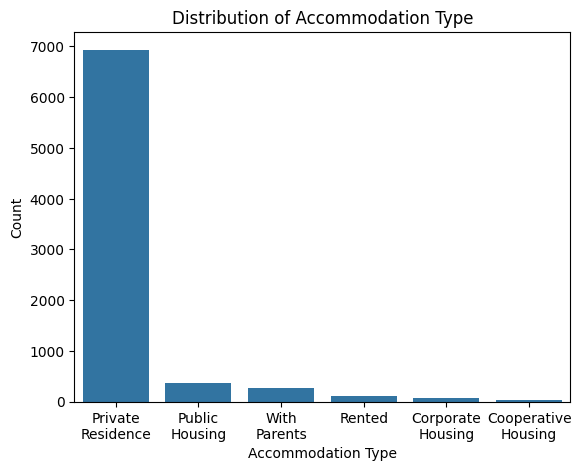

In [35]:
create_bar_plot(cc_train_copy, 'accommodation')

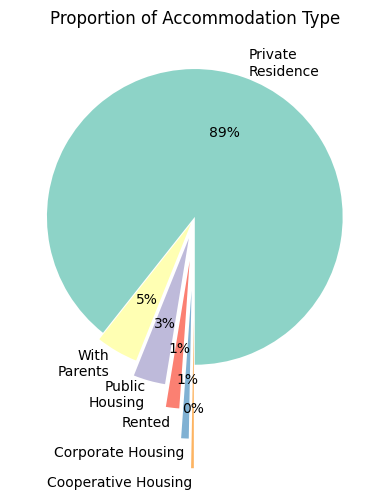

In [36]:
create_pie_plot(cc_train_copy, 'accommodation')

### 3.7 **Annual Income**

In [37]:
gen_info_feat(cc_train_copy, 'annual_income')

Description:
count      7767.00
mean     181047.38
std       98773.14
min       27000.00
25%      112500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: annual_income, dtype: float64
**************************************************
Data type: float64


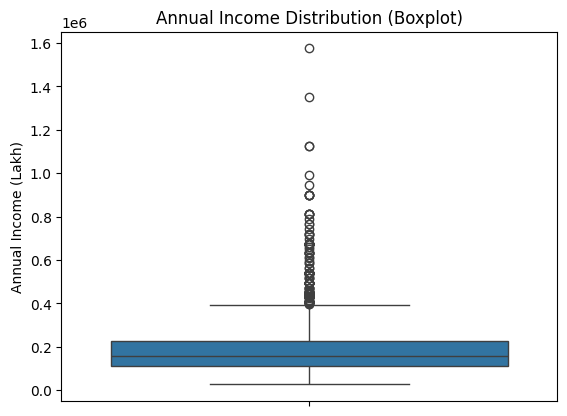

In [38]:
create_boxplot(cc_train_copy, 'annual_income')

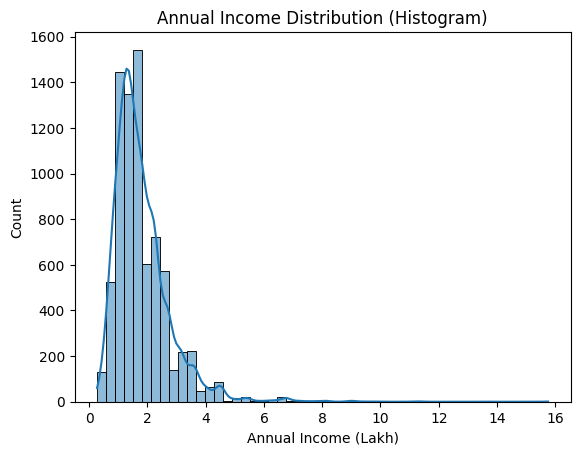

In [39]:
create_hist_plot(cc_train_copy, 'annual_income')

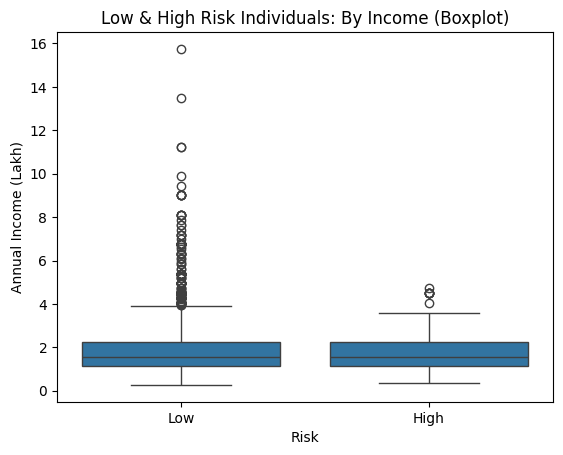

In [40]:
low_high_risk_boxplot(cc_train_copy, 'annual_income')